<a href="https://colab.research.google.com/github/valery2999/proyecto-clasificacion-peliculas-horror-aplicacionesML/blob/main/Proyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table>
    <tr>
        <td><img src="https://s3.amazonaws.com/media-p.slid.es/uploads/1485763/images/9060062/Header.png" width="500"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="font-size:100%;color:blue;text-align:center">    <FONT COLOR="blue"> Entrega Final </p> Aplicaciones de Aprendizaje de Máquina </p> Notebook  </FONT>         </h1></td>         
        <td>
            <tp><p style="font-size:99%;text-align:center">Aplicaciones de Aprendizaje de Máquina </p></tp>
            <tp><p style="font-size:115%;text-align:center">Maestría MACC 2025-1</p></tp>
            <tp><p style="font-size:115%;text-align:center">Prof. Andrés López</p></tp>
            <tp><p style="font-size:115%;text-align:center">Est. Daniel Sierra, Mateo Novoa</p></tp>
            <tp><p style="font-size:115%;text-align:center">Sofía Carrera, Valery Jiménez</p></tp>
        </td>
    </tr>
</table>


### Importar datos

In [ ]:
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import tomotopy as tp

In [ ]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/the-movies-dataset


In [ ]:
file_name = Path(path, 'movies_metadata.csv')
movies = pd.read_csv(file_name, low_memory=False)

###Prepocesamiento

####1)Filtrado de sinopsis vacias

In [ ]:
#Eliminar pel´ıculas sin descripci´on en la variable
movies = movies.dropna(subset=['overview'])

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44512 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  44512 non-null  object 
 1   belongs_to_collection  4435 non-null   object 
 2   budget                 44512 non-null  object 
 3   genres                 44512 non-null  object 
 4   homepage               7765 non-null   object 
 5   id                     44512 non-null  object 
 6   imdb_id                44497 non-null  object 
 7   original_language      44502 non-null  object 
 8   original_title         44512 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             44507 non-null  object 
 11  poster_path            44166 non-null  object 
 12  production_companies   44509 non-null  object 
 13  production_countries   44509 non-null  object 
 14  release_date           44438 non-null  object 
 15  revenue

####2)Filtrado por cantidad de géneros

In [ ]:
def numero_de_generos(texto):
  generos = eval(texto)
  return len(generos)

In [ ]:
#Conservar ´unicamente pel´ıculas que pertenezcan a un solo g´enero, generando una nueva columna genre.
single_genre_movies = movies[movies['genres'].apply(lambda x: len(eval(x)) == 1)]
single_genre_movies.shape

(14138, 24)

####3)Filtrado por géneros válidos

In [ ]:
generos=['Drama', 'Comedy', 'Documentary',
         'Horror', 'Thriller', 'Western',
         'Action', 'Animation', 'Science Fiction',
         'Crime', 'Music','Adventure']

#filtrar por los generos
single_genre_movies = single_genre_movies[single_genre_movies['genres'].apply(lambda x: eval(x)[0]['name'] in generos)]

In [ ]:
single_genre_movies['genres'].unique()

array(["[{'id': 35, 'name': 'Comedy'}]", "[{'id': 18, 'name': 'Drama'}]",
       "[{'id': 99, 'name': 'Documentary'}]",
       "[{'id': 80, 'name': 'Crime'}]",
       "[{'id': 12, 'name': 'Adventure'}]",
       "[{'id': 878, 'name': 'Science Fiction'}]",
       "[{'id': 53, 'name': 'Thriller'}]",
       "[{'id': 27, 'name': 'Horror'}]",
       "[{'id': 16, 'name': 'Animation'}]",
       "[{'id': 28, 'name': 'Action'}]",
       "[{'id': 37, 'name': 'Western'}]",
       "[{'id': 10402, 'name': 'Music'}]"], dtype=object)

####Codficación del género

In [ ]:
#agregar una nueva columna genre_code donde se le asigna un número único por cada género
single_genre_movies['genre_code'] = single_genre_movies['genres'].astype('category').cat.codes

In [ ]:
single_genre_movies = single_genre_movies.drop_duplicates(subset=['title', 'overview']).reset_index(drop=True)

####Filtrado por Fragmentación de sinopsis

In [ ]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

In [ ]:
# Configurar el splitter

splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, model_name="all-mpnet-base-v2",tokens_per_chunk=315)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Función para verificar si la sinopsis se divide en más de un fragmento
def es_un_solo_fragmento(texto):
    trozos = splitter.split_text(texto)
    return len(trozos) == 1

In [ ]:
# Filtrar el DataFrame
df_filtrado = single_genre_movies[single_genre_movies['overview'].apply(es_un_solo_fragmento)].reset_index(drop=True)

## Clasificación del dataset
Elegimos el género Terror

In [ ]:
#Identificar la categoría del género que elegimos
target_genre_name = "Horror"

# Mostrar la categoría de cada género
codigos_generos = dict(enumerate(df_filtrado['genres'].astype('category').cat.categories))
#Sacamos la categoría

for k,v in codigos_generos.items():
  if target_genre_name in v:
    target_genre = k
target_genre

4

In [ ]:
#Variable de reseñas
X_text = df_filtrado['overview'].tolist()
#Convertimos en binaria la variable de género
y = df_filtrado['genre_code'].apply(lambda g: 1 if g == target_genre else 0).tolist()


In [ ]:
vectorizer = CountVectorizer(max_df=0.90,  # Elimina palabras demasiado frecuentes (en mas del 90% de los documentos) o raras (default = 1.0)
                             min_df=5,     # Elimina palabras que aparecen en menos de 5 documentos (si fuera 0.01 eliminaría las palabras que aparecen en menos de 1% de los documentos)
                             max_features=1000, # Limita el vocabulario a las 1000 palabras más comunes.
                             stop_words='english')

vectorizer.fit(X_text)
vocabulario = set(vectorizer.get_feature_names_out())



# Debemos usar un tokenizer compatible con sLDA usando ese vocabulario
tokenized_docs = [
    [word for word in doc.lower().split() if word in vocabulario]
    for doc in X_text
]
#Asignar las etiquetas al documento
docs_labels = [(tokens, label) for tokens, label in zip(tokenized_docs, y) if tokens]

In [ ]:
# Inicializar resultados
resultados = {}

# Validación cruzada estratificada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for p in range(10, 21):
    print(f"\nProbando con {p} temas...")

    # Crear nuevo modelo sLDA
    model = tp.SLDAModel(k=p, alpha=0.1, eta=0.01, seed=42, vars='b')

    # Añadir documentos al modelo
    y_train = []
    for tokens, label in docs_labels:  # X_tokens debe ser lista de listas de tokens
        if tokens:
            model.add_doc(words=tokens, y=[float(label)])
            y_train.append(label)

    # Entrenar el modelo
    model.train(100)

    # Obtener las distribuciones de temas
    X_theta = [doc.get_topic_dist() for doc in model.docs]
    X_theta = np.array(X_theta)
    y_train = np.array(y_train)

    # Entrenar regresión logística
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    scores = cross_val_score(clf, X_theta, y_train, cv=kf, scoring='roc_auc')

    resultados[p] = scores
    print(f"   AUC promedio: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Encontrar mejor p
mejor_p = max(resultados, key=lambda p: np.mean(resultados[p]))
print(f"\nMejor número de temas: {mejor_p} (AUC promedio = {np.mean(resultados[mejor_p]):.4f})")



Probando con 10 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8725 ± 0.0165

Probando con 11 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8728 ± 0.0122

Probando con 12 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8451 ± 0.0076

Probando con 13 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8693 ± 0.0047

Probando con 14 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8665 ± 0.0072

Probando con 15 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8853 ± 0.0067

Probando con 16 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8568 ± 0.0123

Probando con 17 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8924 ± 0.0130

Probando con 18 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8679 ± 0.0098

Probando con 19 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8919 ± 0.0161

Probando con 20 temas...


<ipython-input-118-981df1633365>:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(100)


   AUC promedio: 0.8759 ± 0.0109

Mejor número de temas: 17 (AUC promedio = 0.8924)


In [ ]:
# Entrenamiento final con sLDA
modelo_final = tp.SLDAModel(k=mejor_p, alpha=0.1, eta=0.01, seed=42, vars='b')

# Añadir todos los documentos al modelo
for tokens, label in docs_labels:
    modelo_final.add_doc(words=tokens, y=[float(label)])

# Entrenar el modelo completo
modelo_final.train(100)

# Obtener distribuciones de temas (theta) para cada documento
X_topics_final = [doc.get_topic_dist() for doc in modelo_final.docs]
y_final = [label for _, label in docs_labels]

# Entrenar regresión logística sobre todo el dataset
clf_final = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_final.fit(X_topics_final, y_final)


<ipython-input-119-e5b88a5b5b79>:9: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo_final.train(100)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
# Palabras clave por tema
n_top_words = 10

for k in range(mejor_p):
    print(f"\nTema {k}:")
    top_words = modelo_final.get_topic_words(k, top_n=n_top_words)
    palabras = [word for word, _ in top_words]
    print(" + ".join(palabras))



Tema 0:
young + death + man + soon + begins + doctor + dark + woman + finds + mysterious

Tema 1:
film + comedy + movie + special + live + directed + star + stars + john + music

Tema 2:
world + life + journey + people + documentary + look + years + film + human + history

Tema 3:
men + save + order + group + army + forces + killer + help + island + henry

Tema 4:
make + just + big + job + like + gets + things + way + wants + business

Tema 5:
family + small + town + local + life + village + new + lives + try + old

Tema 6:
old + years + night + time + friends + friend + year + house + decide + trip

Tema 7:
new + york + school + city + high + friends + student + make + people + students

Tema 8:
father + family + young + mother + son + life + daughter + girl + wife + love

Tema 9:
world + war + american + men + time + los + south + women + life + story

Tema 10:
group + black + series + white + people + set + place + young + search + mysterious

Tema 11:
police + united + gang + crim


El análisis del modelo supervisado sLDA revela que algunos temas tienen una influencia significativa en la predicción del género objetivo. El Tema 3, por ejemplo, tiene un coeficiente notablemente alto (15.96), lo que indica una fuerte asociación positiva con la clase positiva —es decir, su presencia en una sinopsis aumenta considerablemente la probabilidad de que la película pertenezca al género objetivo. Este tema está compuesto por palabras como mysterious, house, dead, evil, killer y strange, lo cual sugiere una narrativa típica del género Horror. También se observa que el Tema 14 (coeficiente = 3.96) contribuye positivamente, y está relacionado con contextos escolares y adolescentes (palabras como school, high, students, party).

Por el contrario, varios temas tienen coeficientes negativos, indicando que están asociados con la clase negativa (películas que no pertenecen al género objetivo). Por ejemplo, el Tema 4 (coeficiente = -6.45), con palabras como world, life, documentary, human, se alinea fuertemente con películas documentales o de carácter biográfico, alejadas de lo que se espera en una película de horror. Lo mismo ocurre con el Tema 9 (coeficiente = -3.50), claramente centrado en metacine o películas sobre cine mismo (film, director, interviews), y el Tema 16 (coeficiente = -2.86), relacionado con política y temas sociales. Estos resultados reflejan cómo el modelo logra capturar, mediante los temas latentes, diferencias semánticas que permiten distinguir con precisión las sinopsis del género objetivo respecto a otras.

In [ ]:
# Coeficientes del modelo de regresión por tema
for i, coef in enumerate(clf_final.coef_[0]):
    print(f"Tema {i}: coeficiente = {coef:.4f}")


Tema 0: coeficiente = 10.8636
Tema 1: coeficiente = -3.0681
Tema 2: coeficiente = -5.4155
Tema 3: coeficiente = 4.5046
Tema 4: coeficiente = -0.5004
Tema 5: coeficiente = -0.0593
Tema 6: coeficiente = 5.5346
Tema 7: coeficiente = 3.0303
Tema 8: coeficiente = -1.8253
Tema 9: coeficiente = -4.4553
Tema 10: coeficiente = 10.8993
Tema 11: coeficiente = -3.5076
Tema 12: coeficiente = -2.1915
Tema 13: coeficiente = -6.6912
Tema 14: coeficiente = -2.8025
Tema 15: coeficiente = -1.4597
Tema 16: coeficiente = -3.3469


#### Evaluación del error del modelo seleccionado mediante validación cruzada con k=10 folds mediante ROC-AUC

In [ ]:
# Obtener representaciones theta del modelo sLDA entrenado
X_topics_final = [doc.get_topic_dist() for doc in modelo_final.docs]
y_final = [label for _, label in docs_labels]

# Definir clasificador
clf_final = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Validación cruzada estratificada con k=10
kf_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_10 = cross_val_score(clf_final, X_topics_final, y_final, cv=kf_10, scoring='roc_auc')

# Imprimir resultados
print(f"ROC-AUC promedio (k=10): {np.mean(scores_10):.4f} ± {np.std(scores_10):.4f}")



ROC-AUC promedio (k=10): 0.8924 ± 0.0158


#### Área bajo la curva

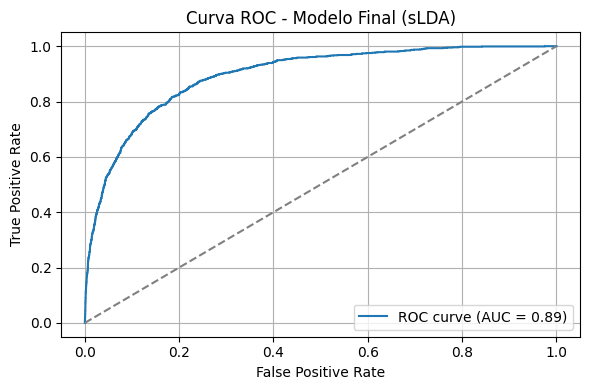

In [ ]:
clf_final = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_final.fit(X_topics_final, y_final)

# Obtener probabilidades de clase positiva
y_proba = clf_final.predict_proba(X_topics_final)[:, 1]

# Calcular curva ROC y AUC
fpr, tpr, _ = roc_curve(y_final, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo Final (sLDA)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



La curva ROC correspondiente al modelo final de sLDA evidencia un desempeño sólido en la tarea de clasificación binaria. Como se muestra en la Figura, la curva se aproxima al vértice superior izquierdo, lo que indica una alta tasa de verdaderos positivos con una baja tasa de falsos positivos. Este comportamiento se corrobora cuantitativamente mediante el valor del Área Bajo la Curva (AUC), que alcanzó un promedio de 0.8924 ± 0.0158 tras una validación cruzada con k = 10. Dicho resultado refleja una excelente capacidad discriminativa del modelo, lo que implica que el modelo es eficaz al diferenciar entre sinopsis pertenecientes al género objetivo (por ejemplo, horror) y aquellas que no lo son. Esta métrica AUC cercana a 0.90 posiciona al modelo como una herramienta confiable para tareas de clasificación temática en textos narrativos del ámbito cinematográfico.

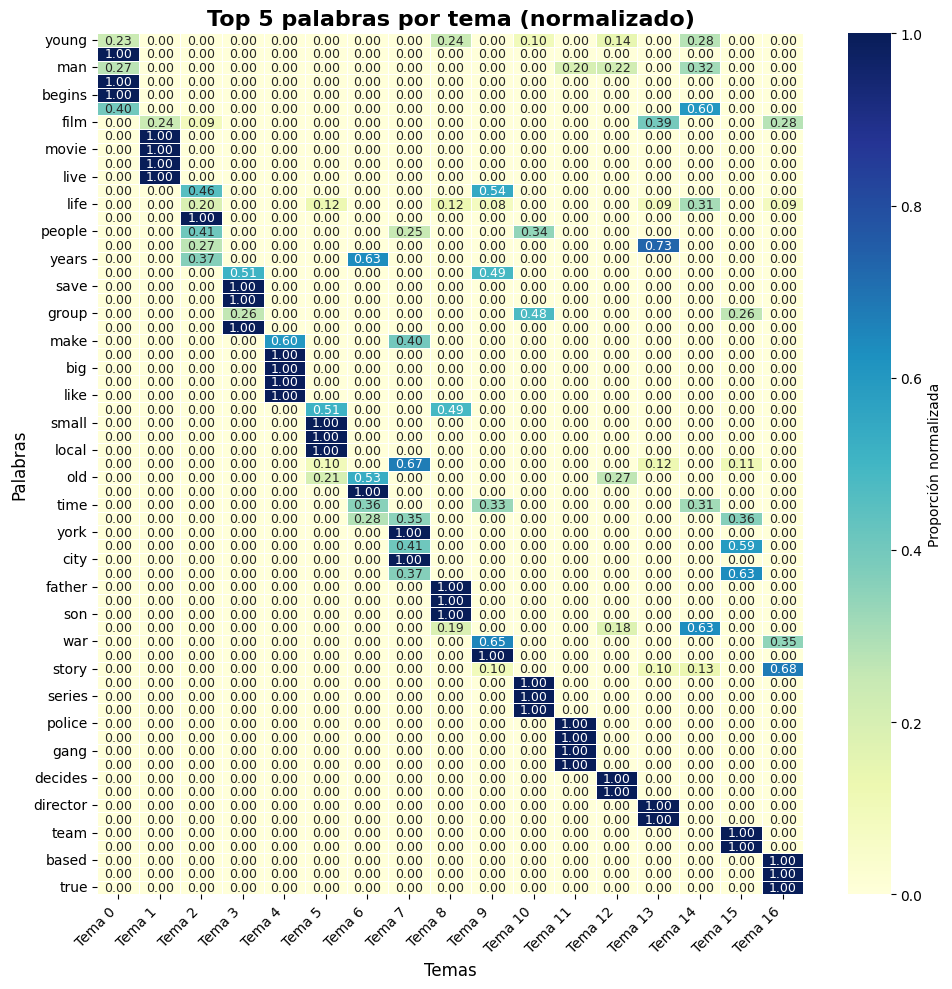

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Selección de top 5 palabras por cada tema ---
top_palabras = set()
for columna in df_topic_words.columns:
    top5 = df_topic_words[columna].sort_values(ascending=False).head(5).index
    top_palabras.update(top5)

# Filtrar solo las palabras seleccionadas
df_top = df_topic_words.loc[df_topic_words.index.isin(top_palabras)]

# Normalizar por fila (opcional, si deseas ver proporción dentro de cada palabra)
df_top_norm = df_top.div(df_top.sum(axis=1), axis=0)

# --- Visualización mejorada ---
plt.figure(figsize=(10, 10))
sns.heatmap(
    df_top_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Proporción normalizada'},
    annot_kws={"fontsize": 9}
)

plt.title("Top 5 palabras por tema (normalizado)", fontsize=16, fontweight='bold')
plt.xlabel("Temas", fontsize=12)
plt.ylabel("Palabras", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

El mapa de calor que representa las cinco palabras más representativas por tema, normalizadas por su proporción, proporciona una visión cualitativa de los tópicos generados por el modelo sLDA entrenado para clasificar películas del género horror. Se observa una diferenciación clara entre temas, con palabras altamente representativas como young, man, war, police y story que dominan tópicos específicos. Aunque algunos temas están asociados a narrativas genéricas o familiares (e.g., “father”, “son”, “life”), otros tópicos presentan vocabulario vinculado a contextos de conflicto, suspenso o crimen, tales como war, gang, police y decides, lo cual puede estar relacionado con el tono oscuro y los elementos de violencia o tensión característicos del cine de horror. Este patrón lingüístico sugiere que el modelo ha captado componentes semánticos relevantes para la clasificación del género, permitiendo interpretar cómo ciertos grupos de palabras contribuyen a la discriminación del género objetivo frente a otros.

## Matriz de confusión de clasificación de Horror

In [ ]:
clf_final = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_final.fit(X_topics_final, y_final)
y_proba = clf_final.predict_proba(X_topics_final)[:, 1]

In [ ]:
y_proba

array([0.26471492, 0.24776296, 0.15416922, ..., 0.68149421, 0.65324453,
       0.10949978])

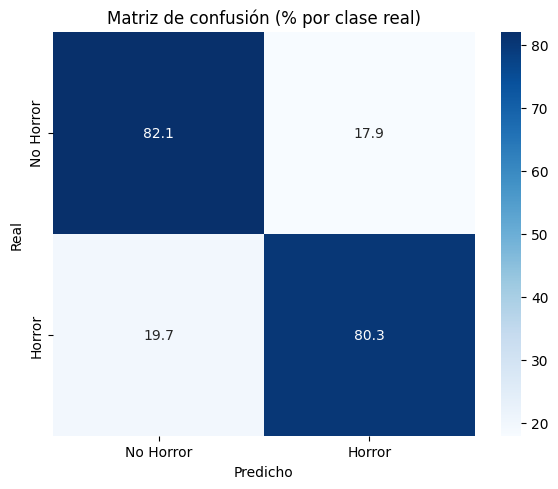

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Predicción binaria a partir de probabilidades
y_pred_final = (y_proba >= 0.5).astype(int)

# Paso 2: Matriz de confusión
cm = confusion_matrix(y_final, y_pred_final)

# Paso 3: Normalización por fila (real) para obtener porcentajes
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Paso 4: Visualización
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=['No Horror', 'Horror'],
            yticklabels=['No Horror', 'Horror'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión (% por clase real)')
plt.tight_layout()
plt.show()


La matriz de confusión expresada en porcentajes por clase real evidencia un desempeño equilibrado del modelo sLDA en la tarea de clasificación binaria del género horror. En particular, el modelo logra identificar correctamente el 80.3 % de las sinopsis que efectivamente pertenecen al género horror (verdaderos positivos), y clasifica adecuadamente el 82.1 % de los casos que no corresponden a dicho género (verdaderos negativos). No obstante, se observa un 19.7 % de falsos negativos —películas de horror clasificadas erróneamente como no horror— y un 17.9 % de falsos positivos —casos no horror etiquetados como horror—. Estos resultados reflejan una capacidad de discriminación sólida y balanceada, lo que respalda la utilidad del modelo en contextos donde se requiere diferenciar contenidos temáticamente oscuros o perturbadores del resto del corpus cinematográfico.

In [ ]:
from sklearn.metrics import classification_report

# Reemplaza estos nombres si usas otros en tu notebook
print("Classification Report:\n")
print(classification_report(y_final, y_pred_final, target_names=["No Horror", "Horror"]))


Classification Report:

              precision    recall  f1-score   support

   No Horror       0.98      0.82      0.89     12715
      Horror       0.25      0.80      0.39       969

    accuracy                           0.82     13684
   macro avg       0.62      0.81      0.64     13684
weighted avg       0.93      0.82      0.86     13684



El reporte de clasificación obtenido para el modelo sLDA revela una precisión global del 82 %, indicando un rendimiento general sólido. La clase No Horror presenta una alta precisión (0.98) y un F1-score de 0.89, lo que sugiere que el modelo es altamente confiable para identificar correctamente las sinopsis que no pertenecen al género horror. Sin embargo, el desempeño en la clase Horror es más problemático: aunque el recall es alto (0.80), lo que implica que el modelo identifica la mayoría de los casos reales de horror, la precisión es baja (0.25), señalando una considerable tasa de falsos positivos. Esto se traduce en un F1-score moderado de 0.39 para dicha clase. El desequilibrio en el conjunto de datos —con una mayoría de sinopsis no horror— puede haber influido en este comportamiento. En general, si bien el modelo muestra una buena sensibilidad para detectar horror, requiere ajustes adicionales para mejorar la especificidad y reducir los errores de clasificación en esta categoría minoritaria.

## Predicción de sinopsis


In [ ]:
sinopsis_nuevas = [
        "A group of five teenagers decides to spend a weekend at one of their family’s old countryside house, far from the city and surrounded by dense forests. What begins as a fun getaway soon turns into a nightmare when they discover the estate hides a dark secret linked to mysterious disappearances that occurred years ago. And started happening again.",
        "A young restorer decides to move into an old house to recover it, without imagining that she is unleashing a nightmare. Soon, chilling phenomena begin to manifest themselves: wailing in the hallways, ghosts in the mirrors and an evil presence that seems to inhabit every corner. Caught between the real and the supernatural, she must face unimaginable horrors if she wants to get out alive.",
        "Clara, a famous writer tired of fame, takes refuge in a seaside town to find herself again. There she meets Julian, a carpenter with a melancholic look. What begins as a silent friendship turns into a deep and sincere love story. As their hearts beat again, they must face the ghosts of the past that threaten to separate them. Sometimes true love comes when you least expect it."
    ]

import re

# Paso 1: Preprocesar y tokenizar
def limpiar_y_tokenizar(texto):
    texto = texto.lower()  # minúsculas
    texto = re.sub(r'[^a-z\s]', '', texto)  # quitar puntuación
    return texto.split()  # tokenizar

tokens_nuevos = [limpiar_y_tokenizar(texto) for texto in sinopsis_nuevas]

# Paso 2: Crear documentos correctamente como lista de palabras
documentos_nuevos = [modelo_final.make_doc(tokens) for tokens in tokens_nuevos]

# Paso 3: Inferir la distribución de temas (theta)
distribuciones_temas = [modelo_final.infer(doc)[0] for doc in documentos_nuevos]

# Paso 4: Convertir a DataFrame para clasificación
X_nuevas = pd.DataFrame(distribuciones_temas)

# Obtener predicciones y probabilidades
y_pred_nuevas = clf_final.predict(X_nuevas)
y_proba_nuevas = clf_final.predict_proba(X_nuevas)

# Mostrar resultados con probabilidad
for i, (texto, pred, proba) in enumerate(zip(sinopsis_nuevas, y_pred_nuevas, y_proba_nuevas)):
    print(f"Sinopsis {i+1}:\n{texto}")
    print(f"Predicción: {'Horror' if pred == 1 else 'No Horror'}")
    print(f"Probabilidad No Horror (0): {proba[0]*100:.2f}%")
    print(f"Probabilidad Horror (1): {proba[1]*100:.2f}%")

Sinopsis 1:
A group of five teenagers decides to spend a weekend at one of their family’s old countryside house, far from the city and surrounded by dense forests. What begins as a fun getaway soon turns into a nightmare when they discover the estate hides a dark secret linked to mysterious disappearances that occurred years ago. And started happening again.
Predicción: Horror
Probabilidad No Horror (0): 2.05%
Probabilidad Horror (1): 97.95%
Sinopsis 2:
A young restorer decides to move into an old house to recover it, without imagining that she is unleashing a nightmare. Soon, chilling phenomena begin to manifest themselves: wailing in the hallways, ghosts in the mirrors and an evil presence that seems to inhabit every corner. Caught between the real and the supernatural, she must face unimaginable horrors if she wants to get out alive.
Predicción: Horror
Probabilidad No Horror (0): 6.64%
Probabilidad Horror (1): 93.36%
Sinopsis 3:
Clara, a famous writer tired of fame, takes refuge in 

Con el fin de ilustrar la capacidad del modelo para clasificar sinopsis ficticias, se evaluaron tres ejemplos representativos. Las dos primeras narrativas fueron clasificadas correctamente como horror, ambas con altas probabilidades asociadas (97.95 % y 93.36 %, respectivamente). Estas sinopsis contienen elementos canónicos del género, como desapariciones misteriosas, presencias malignas y aislamiento espacial, que el modelo reconoce con alta certeza. En cambio, la tercera sinopsis, centrada en una historia de amor entre una escritora y un carpintero en un pueblo costero, fue identificada como no horror con una probabilidad del 88.55 %. Este resultado reafirma que el modelo distingue correctamente entre tramas con tono emocional o romántico y aquellas de índole oscura o sobrenatural, demostrando una adecuada sensibilidad temática en el proceso de clasificación.
